In [3]:
import os
import numpy as np
import cv2
import matplotlib.pyplot as plt
from scipy.io import loadmat
from scipy.signal import spectrogram
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
from tensorflow.keras.callbacks import EarlyStopping

In [9]:
def convert_to_spectrogram(data, fs=250, nperseg=128, img_size=(32, 32), batch_size=1000):
    spectrogram_images = []
    num_batches = (len(data) + batch_size - 1) // batch_size  # Calculate number of batches
    
    for batch_idx in range(num_batches):
        batch_data = data[batch_idx * batch_size: (batch_idx + 1) * batch_size]
        
        for signal_data in batch_data:
            # Ensure signal_data is 1D
            signal_data = np.asarray(signal_data).squeeze()
            
            # Handle short signals by padding
            if len(signal_data) < nperseg:
                signal_data = np.pad(signal_data, (0, nperseg - len(signal_data)), 'constant')
            
            # Compute spectrogram
            f, t, Sxx = spectrogram(signal_data, fs=fs, nperseg=nperseg)
            Sxx = np.log(Sxx + 1e-8)  # Log-scale for better visibility
            
            # Average across frequency bins to reduce dimensionality
            Sxx_avg = np.mean(Sxx, axis=0)  # Average across the frequency dimension
            
            # Resize spectrogram to fixed image size
            img = cv2.resize(Sxx_avg, img_size)
            
            # Normalize the image
            img = (img - np.mean(img)) / np.std(img)
            spectrogram_images.append(img)  # Append directly
        
        if (batch_idx + 1) % 10 == 0:
            print(f"Processed batch {batch_idx + 1} / {num_batches}")
    
    return np.array(spectrogram_images)

In [10]:
# Function to load normal ECG data from a text file
def load_normal_ecg_data(file_path):
    try:
        with open(file_path, 'r') as file:
            lines = file.readlines()

        ecg_data = []
        labels = []

        for line in lines:
            try:
                values = list(map(float, line.split()))
                if len(values) > 0:
                    ecg_data.append(values)
                    labels.append(0)  # Placeholder label for normal data
            except ValueError:
                continue

        return np.array(ecg_data), np.array(labels)
    
    except Exception as e:
        print(f"Error loading text file {file_path}: {e}")
        return None, None

In [11]:
# Function to load arrhythmic ECG data from folders
def load_arrhythmic_ecg_data(root_folder):
    all_data = []
    all_labels = []
    
    label_mapping = {'0': 0, '1': 1}  # Modify based on your dataset
    
    for subdir, dirs, files in os.walk(root_folder):
        for file in files:
            if file.endswith('.mat'):
                file_path = os.path.join(subdir, file)
                try:
                    mat_data = loadmat(file_path)
                    if 'val' in mat_data:
                        ecg_data = mat_data['val'].squeeze()
                        label = 1  # Placeholder for arrhythmic data label
                        all_labels.append(label)
                        all_data.append(ecg_data)
                except Exception as e:
                    print(f"Error loading MATLAB file {file_path}: {e}")

    all_data = np.array(all_data)
    all_labels = np.array(all_labels)
    return all_data, all_labels

In [12]:
# Load normal ECG data
normal_file_path = r'C:\Users\diyu2\OneDrive - AUT University\AUT YEAR 4\INDUSTRIAL PROJECT (Mechanical)\Reports Part B\testing_ecg.txt'
print("Loading normal ECG data...")
normal_data, normal_labels = load_normal_ecg_data(normal_file_path)

# Display the shape of the normal ECG data
print(f"Original Normal Data Shape: {normal_data.shape}")

# Load arrhythmic ECG data
arrhythmic_root_folder = r'C:\Users\diyu2\OneDrive - AUT University\AUT YEAR 4\INDUSTRIAL PROJECT (Mechanical)\Reports Part B\ECG database-for-arrhythmia\WFDBRecords'
print("Loading arrhythmic ECG data...")
arrhythmic_data, arrhythmic_labels = load_arrhythmic_ecg_data(arrhythmic_root_folder)

# Display the shape of the arrhythmic ECG data
print(f"Arrhythmic Data Shape: {arrhythmic_data.shape}")

# Reshape normal data to have a third dimension
normal_data = np.expand_dims(normal_data, axis=-1)  # Shape: (5000, 12, 1)
print(f"Expanded Normal Data Shape: {normal_data.shape}")

# Pad the normal data along the time axis to match the arrhythmic data's time step (5000 samples)
normal_data = np.pad(normal_data, ((0, 0), (0, 0), (0, arrhythmic_data.shape[2] - 1)), mode='constant')
print(f"Padded Normal Data Shape: {normal_data.shape}")

# Combine both datasets
combined_data = np.concatenate((normal_data, arrhythmic_data), axis=0)
combined_labels = np.concatenate((normal_labels, arrhythmic_labels), axis=0)

# Display combined data shape
print(f"Combined Data Shape: {combined_data.shape}")
print(f"Combined Labels Shape: {combined_labels.shape}")


Loading normal ECG data...
Original Normal Data Shape: (5000, 12)
Loading arrhythmic ECG data...
Arrhythmic Data Shape: (5000, 12, 5000)
Expanded Normal Data Shape: (5000, 12, 1)
Padded Normal Data Shape: (5000, 12, 5000)
Combined Data Shape: (10000, 12, 5000)
Combined Labels Shape: (10000,)


In [13]:
# Convert ECG signals to spectrogram images
print("Converting ECG signals to spectrogram images...")
spectrogram_images = convert_to_spectrogram(combined_data, fs=250, nperseg=128, img_size=(32, 32))

# Check the shape of spectrogram images
print(f"Shape of spectrogram images: {spectrogram_images.shape}")

# Reshape for CNN: (num_samples, height, width, channels)
X_spectrograms = spectrogram_images.reshape(spectrogram_images.shape[0], 32, 32, 1)


Converting ECG signals to spectrogram images...
Processed batch 10 / 10
Shape of spectrogram images: (10000, 32, 32)


In [14]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_spectrograms, combined_labels, test_size=0.2, random_state=42, stratify=combined_labels)

# Check the shape of the data
print(f'Shape of training data: {X_train.shape}')
print(f'Shape of testing data: {X_test.shape}')
print(f'Shape of labels: {y_train.shape}, {y_test.shape}')

Shape of training data: (8000, 32, 32, 1)
Shape of testing data: (2000, 32, 32, 1)
Shape of labels: (8000,), (2000,)


In [23]:
# Build the CNN model
model = Sequential([
    Conv2D(filters=32, kernel_size=(3, 3), activation='relu', input_shape=(32, 32, 1)),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.25),
    
    Conv2D(filters=64, kernel_size=(3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.25),
    
    Conv2D(filters=128, kernel_size=(3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.25),
    
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')  # Adjust for binary classification
])

C:\Users\diyu2\anaconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [24]:
# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Display the model architecture
model.summary()

# Early stopping to prevent overfitting
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train the model
history = model.fit(
    X_train, y_train,
    epochs=20,
    batch_size=32,
    validation_data=(X_test, y_test),
    callbacks=[early_stop],
    verbose=1
)

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)               │ (None, 30, 30, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 15, 15, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 15, 15, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 13, 13, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 6, 6, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 6, 6, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 4, 4, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 2, 2, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 2, 2, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │        65,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 158,465 (619.00 KB)

 Trainable params: 158,465 (619.00 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 11s 22ms/step - accuracy: 0.9537 - loss: 0.0785 - val_accuracy: 1.0000 - val_loss: 9.3751e-09
Epoch 2/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 5s 18ms/step - accuracy: 1.0000 - loss: 9.9279e-06 - val_accuracy: 1.0000 - val_loss: 8.2411e-09
Epoch 3/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 4s 17ms/step - accuracy: 1.0000 - loss: 1.5261e-06 - val_accuracy: 1.0000 - val_loss: 5.5675e-09
Epoch 4/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 5s 18ms/step - accuracy: 1.0000 - loss: 1.1624e-06 - val_accuracy: 1.0000 - val_loss: 3.4775e-09
Epoch 5/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 4s 18ms/step - accuracy: 1.0000 - loss: 1.1629e-06 - val_accuracy: 1.0000 - val_loss: 1.9932e-09
Epoch 6/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 4s 18ms/step - accuracy: 1.0000 - loss: 4.7591e-07 - val_accuracy: 1.0000 - val_loss: 1.3726e-09
Epoch 7/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 4s 18ms/step - accuracy: 1.0000 - loss: 5.5204e-07 - val_accuracy: 1.0000 - val_loss: 8.0957e-10
Epoch 8/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 4s 1

In [25]:
# Evaluate the model on the test data
test_loss, test_acc = model.evaluate(X_test, y_test, verbose=0)
print(f'\nTest Accuracy: {test_acc * 100:.2f}%')


Test Accuracy: 100.00%


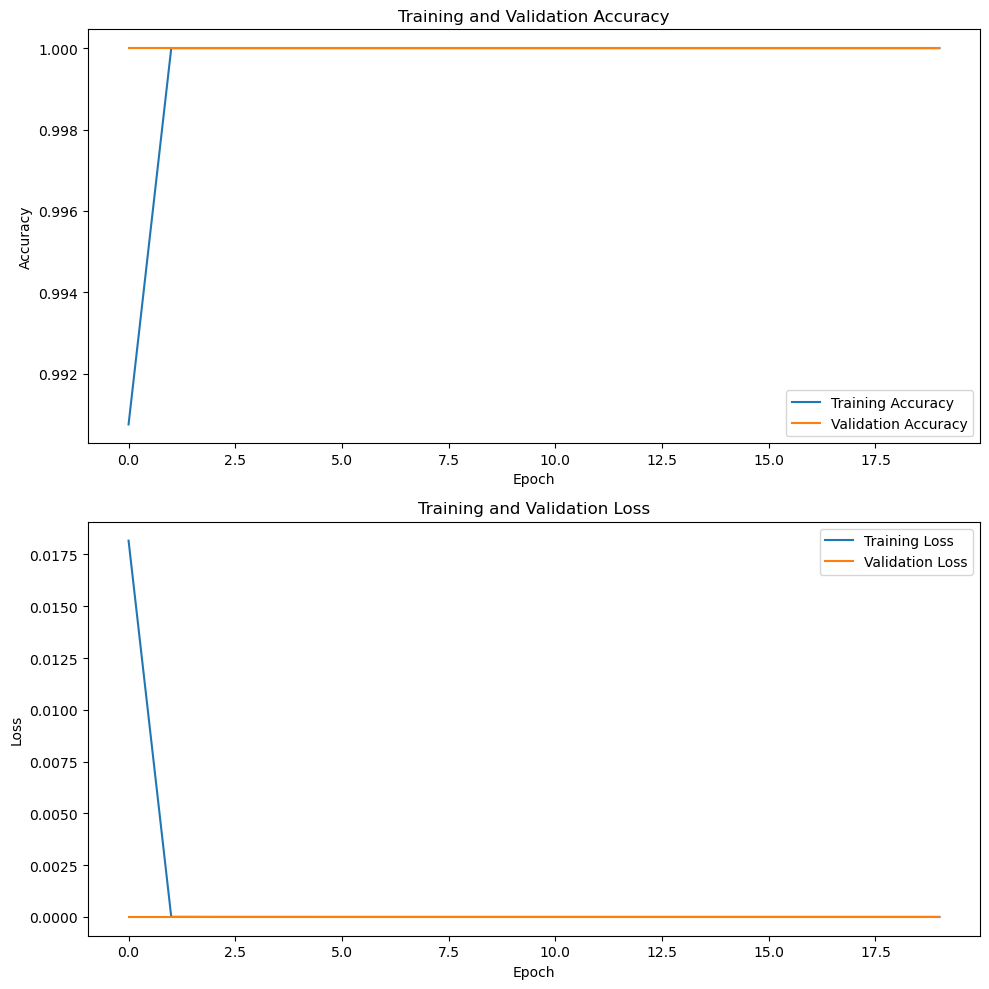

In [26]:
# Plotting the training and validation accuracy and loss
fig, axs = plt.subplots(2, 1, figsize=(10, 10))

# Accuracy plot
axs[0].plot(history.history['accuracy'], label='Training Accuracy')
axs[0].plot(history.history['val_accuracy'], label='Validation Accuracy')
axs[0].set_xlabel('Epoch')
axs[0].set_ylabel('Accuracy')
axs[0].set_title('Training and Validation Accuracy')
axs[0].legend(loc='lower right')

# Loss plot
axs[1].plot(history.history['loss'], label='Training Loss')
axs[1].plot(history.history['val_loss'], label='Validation Loss')
axs[1].set_xlabel('Epoch')
axs[1].set_ylabel('Loss')
axs[1].set_title('Training and Validation Loss')
axs[1].legend(loc='upper right')

plt.tight_layout()
plt.show()

63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step


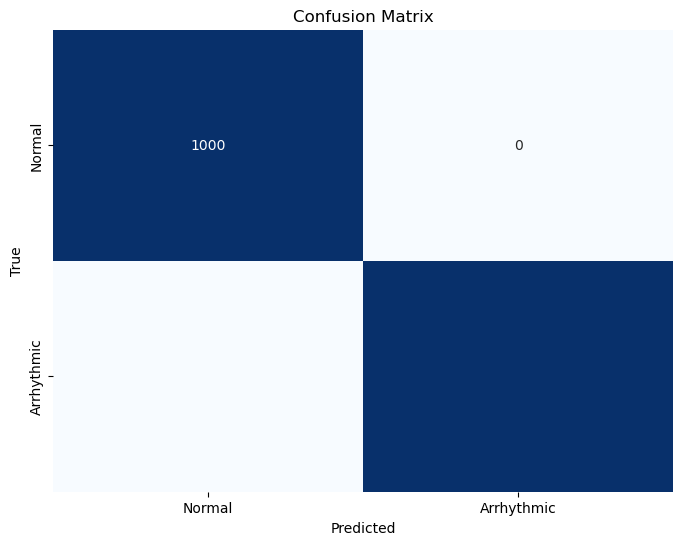


Classification Report:
              precision    recall  f1-score   support

      Normal       1.00      1.00      1.00      1000
  Arrhythmic       1.00      1.00      1.00      1000

    accuracy                           1.00      2000
   macro avg       1.00      1.00      1.00      2000
weighted avg       1.00      1.00      1.00      2000



In [27]:
# Predict on the test set
y_pred_prob = model.predict(X_test)
y_pred = (y_pred_prob > 0.5).astype(int)

# Confusion matrix plotting function
def plot_confusion_matrix(y_true, y_pred, class_names):
    cm = confusion_matrix(y_true, y_pred)
    
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False, 
                xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()

# Plot confusion matrix
plot_confusion_matrix(y_test, y_pred, class_names=['Normal', 'Arrhythmic'])

# Classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=['Normal', 'Arrhythmic']))